In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os
from os import getcwd
import random
from shutil import copyfile
import zipfile
import shutil

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
local_zip = "/content/dataset.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:

train_dir = '/tmp/Images/train/'
test_dir = '/tmp/Images/test/'
train_csv = pd.read_csv('/content/train.csv')
test_csv = pd.read_csv('/content/test.csv')

In [4]:
train_csv.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


In [5]:
labels=train_csv.label.unique()
arr=np.asarray(['training','testing','source'])

In [6]:
os.mkdir(r'/content/images')
for a in arr:
  os.mkdir(r'/content/images/'+a)
  for l in labels:
    os.mkdir(r'/content/images/'+a+'/'+str(l))

In [7]:
files = []
for  r, d, f in os.walk(train_dir):
    for file in f:
        if '.png' in file:
            files.append(file)

49000

In [8]:
for filename in files:
  label = train_csv[train_csv.filename==filename].label.unique()[0]
  init_path = os.path.join(train_dir,filename)
  final_path = os.path.join('/content/images/source/'+str(label)+'/',filename)
  copyfile(init_path,final_path)

In [9]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    shuffle=random.sample(os.listdir(SOURCE),len(os.listdir(SOURCE)))
    train_data_length=int(len(os.listdir(SOURCE))*SPLIT_SIZE)
    test_data_length=int(len(os.listdir(SOURCE))-train_data_length)
    train_data=shuffle[0:train_data_length]
    test_data=shuffle[-test_data_length:]
    for x in train_data:
        train_temp=os.path.join(SOURCE,x)
        final_train=os.path.join(TRAINING,x)
        copyfile(train_temp,final_train)
    for x in test_data:
        test_temp=os.path.join(SOURCE,x)
        final_test=os.path.join(TESTING,x)
        copyfile(test_temp,final_test)

In [10]:
split_size = 0.8

for l in labels:
  source_dir = '/content/images/source/'+str(l)+'/'
  train_dir = '/content/images/training/'+str(l)+'/'
  test_dir = '/content/images/testing/'+str(l)+'/'
  split_data(source_dir, train_dir, test_dir, split_size)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_dir = "/content/images/training"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(training_dir,
                                                   target_size=(28,28),
                                                   color_mode = 'grayscale',
                                                   batch_size=128,
                                                   class_mode='categorical')

val_dir = "/content/images/testing"
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(28,28),
                                                color_mode = 'grayscale',
                                                batch_size=128,
                                                class_mode='categorical')

Found 39196 images belonging to 10 classes.
Found 9804 images belonging to 10 classes.


In [12]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import tensorflow as tf

In [ ]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(28, 28,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(10, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [14]:
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = val_generator.n//val_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

callbacks = [reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=3,
    validation_data = val_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

Epoch 1/3
306/306 [==============================] - 814s 3s/step - loss: 0.3664 - accuracy: 0.8822 - val_loss: 9.3756 - val_accuracy: 0.1125 - lr: 5.0000e-04
Epoch 2/3
306/306 [==============================] - 825s 3s/step - loss: 0.0937 - accuracy: 0.9711 - val_loss: 0.1810 - val_accuracy: 0.9443 - lr: 5.0000e-04
Epoch 3/3
306/306 [==============================] - 829s 3s/step - loss: 0.0679 - accuracy: 0.9787 - val_loss: 0.0482 - val_accuracy: 0.9861 - lr: 5.0000e-04


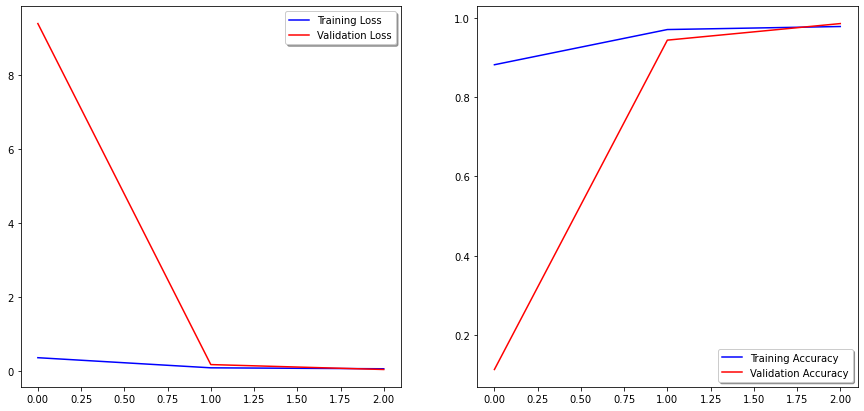

In [17]:

plt.figure(figsize=(15,7))
ax1 = plt.subplot(1,2,1)
ax1.plot(history.history['loss'], color='b', label='Training Loss') 
ax1.plot(history.history['val_loss'], color='r', label = 'Validation Loss',axes=ax1)
legend = ax1.legend(loc='best', shadow=True)
ax2 = plt.subplot(1,2,2)
ax2.plot(history.history['accuracy'], color='b', label='Training Accuracy') 
ax2.plot(history.history['val_accuracy'], color='r', label = 'Validation Accuracy')
legend = ax2.legend(loc='best', shadow=True)

In [58]:
filen = []
for  r, d, f in os.walk("/tmp/Images/test"):
    for fil in f:
        if '.png' in fil:
            filen.append(fil)

In [59]:
os.mkdir('/content/images/tests')
os.mkdir('/content/images/tests/unknown')

In [60]:
for x in filen:
    train_temp = os.path.join("/tmp/Images/test",x)
    final_train = os.path.join('/content/images/tests/unknown',x)
    copyfile(train_temp, final_train)

In [61]:
tests_dir = '/content/images/tests'
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(tests_dir,
                                                  target_size = (28,28),
                                                  color_mode = 'grayscale',
                                                  batch_size=128,
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=42)

Found 21000 images belonging to 1 classes.


In [65]:
 test_generator.filenames[1].split('/')[1]

'49001.png'

In [62]:
img_list = []
for x in test_generator.filenames:
    x = x.split('/')[1]
    img_list.append(x)

In [66]:
predictions = model.predict_generator(test_generator)
predictions[:2]

Instructions for updating:
Please use Model.predict, which supports generators.


array([[7.6281594e-08, 2.0747425e-06, 1.3565479e-07, 4.2412078e-09,
        9.9999404e-01, 2.7129145e-08, 8.5043547e-07, 1.9701895e-06,
        9.4501480e-08, 7.0162298e-07],
       [9.9905306e-01, 1.5731082e-05, 1.0401434e-04, 8.2421475e-06,
        7.8393796e-06, 1.3602255e-05, 6.9750194e-04, 5.1846623e-06,
        5.6504582e-06, 8.9207941e-05]], dtype=float32)

In [67]:
predicted_clases = np.argmax(predictions,axis=-1)
train_generator.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [68]:
sample_csv=pd.read_csv("/content/sample_submission.csv")

sample_csv.head()

,filename,label
0,49000.png,0
1,49001.png,0
2,49002.png,0
3,49003.png,0
4,49004.png,0


In [69]:
data = {'filename': img_list, 'label': predicted_clases}
df = pd.DataFrame(data)

df.head()

,filename,label
0,49000.png,4
1,49001.png,0
2,49002.png,9
3,49003.png,7
4,49004.png,9


In [71]:
df.to_csv('new_submission.csv', index=False)